In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [10]:
# Load and prepare the data
pred_df = pd.read_csv("/Users/christianhellum/Cand. Merc./Data-Science-Project/data_science_project/Beat the bookies/data/df_preprocessed.csv", index_col=0)
pred_df.columns

Index(['Date', 'Home', 'Away', 'FTR', 'Attendance', 'B365H', 'B365D', 'B365A',
       'AttackStrengthHome', 'AttackStrengthAway', 'DefenseWeaknessHome',
       'DefenseWeaknessAway', 'AvgHomePoints', 'AvgAwayPoints',
       'AvgLosingHomePoints', 'AvgLosingAwayPoints', 'AvgGoalDiffHome',
       'AvgGoalDiffAway', 'HomeWinsRatio', 'HomeDrawsRatio', 'AwayWinsRatio',
       'AwayDrawsRatio', 'AvgHomeCornersLast5', 'AvgAwayCornersLast5',
       'AvgHomeShotsLast5', 'AvgHomeShotsOnTargetLast5', 'AvgAwayShotsLast5',
       'AvgAwayShotsOnTargetLast5', 'elo', 'elo_away', 'FormHomeTeam',
       'FormAwayTeam', 'ProbabilityDraw', 'ProbabilityHomeWin',
       'ProbabilityAwayWin'],
      dtype='object')

In [9]:
pred_df

Date Home Away FTR  Attendance  B365H  B365D  B365A  \
0    2019-08-16    2    4   H     47693.0   5.25   3.80   1.65   
1    2019-08-17    6   21   A     23566.0   4.75   4.20   1.65   
2    2019-08-17   24   22   D     41846.0   1.66   3.75   5.50   
3    2019-08-17   18    8   H     15127.0   2.80   3.20   2.60   
4    2019-08-17   16   19   A     10020.0   2.00   3.20   4.20   
...         ...  ...  ...  ..         ...    ...    ...    ...   
1855 2024-05-05   19    5   A     18300.0   3.20   3.25   2.38   
1856 2024-05-05    6   26   H     19548.0   2.30   3.60   2.88   
1857 2024-05-05   24    0   A     44643.0   2.10   3.00   4.00   
1858 2024-05-05   20    1   A     10864.0   1.57   4.00   5.75   
1859 2024-05-05   23   13   H     32658.0   1.65   4.00   5.25   

      AttackStrengthHome  AttackStrengthAway  ...  AvgAwayShotsLast5  \
0               0.000000            0.000000  ...                0.0   
1               0.000000            0.000000  ...                0.0   
2               0.000000            0.000000  ...                0.0   
3               0.000000            0.000000  ...                0.0   
4               0.000000            0.000000  ...                0.0   
...                  ...                 ...  ...                ...   
1855            0.034274            0.044503  ...               11.0   
1856            0.028226            0.065104  ...                9.0   
1857            0.038076            0.028497  ...                9.8   
1858            0.032064            0.041344  ...                8.2   
1859            0.046092            0.033505  ...                8.6   

      AvgAwayShotsOnTargetLast5          elo     elo_away  FormHomeTeam  \
0                           0.0  1722.019409  2001.228638      0.000000   
1                           0.0  1681.163452  1841.848999      0.000000   
2                           0.0  1813.655029  1719.431152      0.000000   
3                           0.0  1566.961060  1712.778198      0.000000   
4                           0.0  1670.794800  1641.649048      0.000000   
...                         ...          ...          ...           ...   
1855                        4.4  1629.822266  1696.406372   2057.936660   
1856                        3.4  1628.082397  1724.820923   2338.240591   
1857                        3.4  1687.701660  1622.472412   2059.229795   
1858                        2.6  1621.235840  1527.045044   2925.893320   
1859                        2.6  1696.177856  1563.006226   3392.680273   

      FormAwayTeam  ProbabilityDraw  ProbabilityHomeWin  ProbabilityAwayWin  \
0         0.000000         0.226260            0.127955            0.645785   
1         0.000000         0.239320            0.266267            0.494412   
2         0.000000         0.229859            0.616701            0.153439   
3         0.000000         0.240204            0.286297            0.473499   
4         0.000000         0.237143            0.533531            0.229326   
...            ...              ...                 ...                 ...   
1855   2057.038916         0.241897            0.398349            0.359754   
1856   3718.007305         0.241856            0.355002            0.403142   
1857   1340.504648         0.233489            0.580879            0.185632   
1858   1647.954297         0.229864            0.616662            0.153475   
1859    672.267695         0.224066            0.661280            0.114654   

      B365_guess  
0              A  
1              A  
2              H  
3              A  
4              H  
...          ...  
1855           A  
1856           H  
1857           H  
1858           H  
1859           H  

[1860 rows x 36 columns]

In [11]:
pred_df['Home'] = pred_df['Home'].astype('category')
pred_df['Away'] = pred_df['Away'].astype('category')
pred_df['FTR'] = pred_df['FTR'].astype('category')

# Ensure 'Date' is in datetime format
pred_df['Date'] = pd.to_datetime(pred_df['Date'])

# Split data into train and test sets
train = pred_df[pred_df['Date'] < '2024-01-01']
test = pred_df[pred_df['Date'] >= '2024-01-01']

# Define predictors and target for train and test sets
X_train = train[['Home', 'Away', 'Attendance', 'B365H', 'B365D', 'B365A',
       'AttackStrengthHome', 'AttackStrengthAway', 'DefenseWeaknessHome',
       'DefenseWeaknessAway', 'AvgHomePoints', 'AvgAwayPoints',
       'AvgLosingHomePoints', 'AvgLosingAwayPoints', 'AvgGoalDiffHome',
       'AvgGoalDiffAway', 'HomeWinsRatio', 'HomeDrawsRatio', 'AwayWinsRatio',
       'AwayDrawsRatio', 'AvgHomeCornersLast5', 'AvgAwayCornersLast5',
       'AvgHomeShotsLast5', 'AvgHomeShotsOnTargetLast5', 'AvgAwayShotsLast5',
       'AvgAwayShotsOnTargetLast5', 'elo', 'elo_away', 'FormHomeTeam',
       'FormAwayTeam', 'ProbabilityDraw', 'ProbabilityHomeWin',
       'ProbabilityAwayWin']]
y_train = train['FTR']
X_test = test[X_train.columns]
y_test = test['FTR']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Define the parameter grid with stricter regularization
param_grid = {
    'n_estimators': [50, 500],  # Use fewer estimators to reduce complexity
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']  # Limit the number of features considered for splitting at each node
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)

# Initialize GridSearchCV with TimeSeriesSplit on training set only
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}


In [13]:
# Train the best model on the entire training set
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions on training set
y_train_pred = best_rf_model.predict(X_train_scaled)

# Make predictions on test set
y_test_pred = best_rf_model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print(f"Training Accuracy with Best Random Forest: {train_accuracy:.4f}")
print(f"Test Accuracy with Best Random Forest: {test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix - Training Set with Best Random Forest")
print(confusion_matrix(y_train, y_train_pred))

print("Confusion Matrix - Test Set with Best Random Forest")
print(confusion_matrix(y_test, y_test_pred))

# Print classification report
print("Classification Report - Training Set with Best Random Forest")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set with Best Random Forest")
print(classification_report(y_test, y_test_pred))

Training Accuracy with Best Random Forest: 0.6106
Test Accuracy with Best Random Forest: 0.5312
Confusion Matrix - Training Set with Best Random Forest
[[276  19 176]
 [103 107 261]
 [ 91  12 655]]
Confusion Matrix - Test Set with Best Random Forest
[[24  7 18]
 [ 8  3 27]
 [ 9  6 58]]
Classification Report - Training Set with Best Random Forest
              precision    recall  f1-score   support

           A       0.59      0.59      0.59       471
           D       0.78      0.23      0.35       471
           H       0.60      0.86      0.71       758

    accuracy                           0.61      1700
   macro avg       0.65      0.56      0.55      1700
weighted avg       0.64      0.61      0.58      1700

Classification Report - Test Set with Best Random Forest
              precision    recall  f1-score   support

           A       0.59      0.49      0.53        49
           D       0.19      0.08      0.11        38
           H       0.56      0.79      0.66        

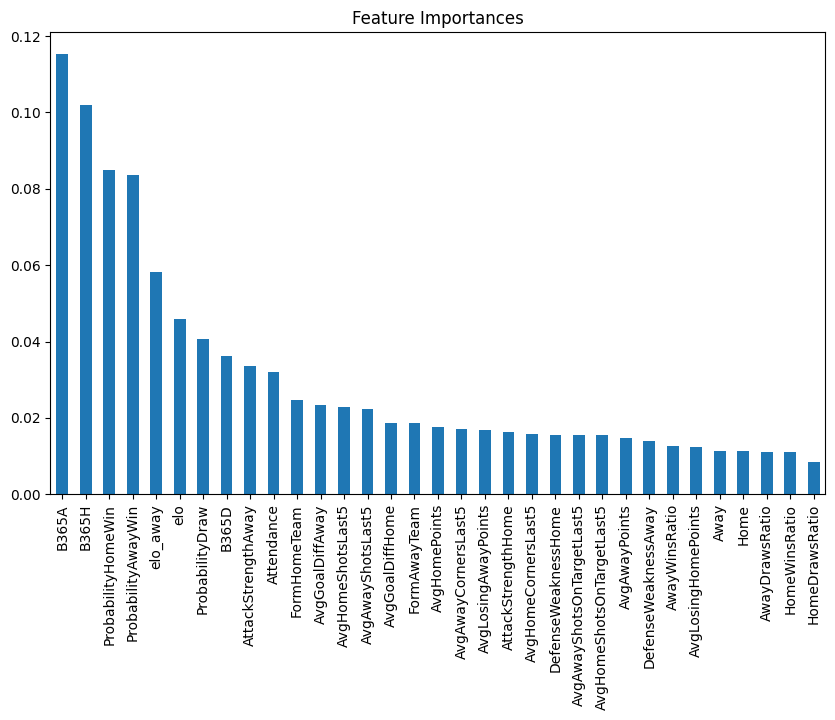

In [14]:
import matplotlib.pyplot as plt

# Extract feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

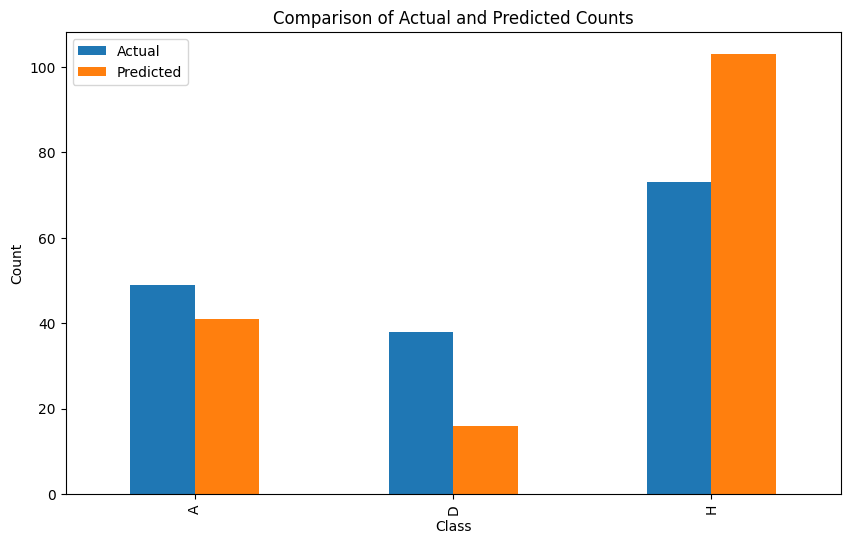

In [15]:
# Count the number of occurrences for each class in actual and predicted values
actual_counts = y_test.value_counts().sort_index()
predicted_counts = pd.Series(y_test_pred).value_counts().sort_index()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts}).fillna(0)

# Plot the comparison
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Comparison of Actual and Predicted Counts')
plt.show()